## Boundary Element Method for Acoustics

### Comparison between triangular and quadrilateral constant elements

In this section, the same internal and external problem will be solved using the BEM and constant elements: triangular and quadrilateral elements. The problem which will be solved is the vibrating cylinder.

The vibrating cylinder is a classical wave propagation problem in 2D and 3D space in which an infinite cylinder is let to vibrate in a free-space domain. This problem closely resembles Green's point source perturbation of an infinite domain. 

The problem is stated as such: let an infinite acoustically rigid cylinder vibrate in an infinite acoustic domain, what is the velocity potential and acoustic pressure field in the vicinities of the cylinder, in a plane parallel to the radial direction? 

The walls of the cylinder are subjected to Neumann boundary conditions ($\frac{\partial \phi}{\partial n} = \bar{q}$). The analytical solution is

\begin{equation}\label{cyl_anal}
	\phi_{cyl} (r) = - \frac{V}{k} \frac{H_0 ^{(2)} (k r)}{H_1 ^{(2)} (k a)},
\end{equation}
where $V$ is the amplitude of the cylinder vibration (set to unity), $k$ is the wave number, $a$ is the radius of the cylinder, $r$ is the distance from the cylinder, $H_0 ^{(2)}$ and $H_1 ^{(2)}$ are the Hankel functions of second species and order 0 and 1, respectively. 

#### Internal problem - acoustic duct

In order to assess the validity of the programs, a simple internal acoustics problem will be solved using the triangular and quadrilateral elements: the acoustic duct problem. This problem consists of a cylindrical duct which can be either open on both ends, closed on one end and open on the other or closed in both ends. The analytical solution can be obtained by solving the time-harmonic wave equation by separation of variables and the resonance frequencies are given by
- closed duct on both ends
\begin{equation}
    F_{closed\ duct}\ (n,L) = \frac{\pi\ n\ c}{L}
\end{equation}
where $c$ is the wave propagation speed, $n=0,1,2,...$ is the mode number and $L$ is the length of the duct. The frequency is in rad/s, divide it to $2\ pi$ to obtain the frequency in Hz. The duct which will be studied has length = 100 mm and diameter = 10 mm. The speed of sound is $c = 343$ m/s and only the first non-zero mode will be studied ($n=1$).

The acoustic flux is zero at the walls of the duct. So a Neumann boundary condition is applied to the whole boundary, such that $\frac{\partial \phi}{\partial n} = \bar{q}$.

In [26]:
c = 343*1000 # Speed of propagation in mm/s
F_closed(n,L,c) = pi*n*c/L # Analytical resonance frequency in rad/s
for n=1:3
    println("Mode n = $(n), L = $(L=100) m, F = $(F_closed(n,L,c)/(2*pi)) Hz.")
end

Mode n = 1, L = 100 m, F = 1715.0 Hz.
Mode n = 2, L = 100 m, F = 3430.0 Hz.
Mode n = 3, L = 100 m, F = 5145.0 Hz.


Notice that the actual solution is simply a time and space harmonic in which the velocity potential (proportional to the acoustic pressure) assumes its maximum value at the walls of the duct. 

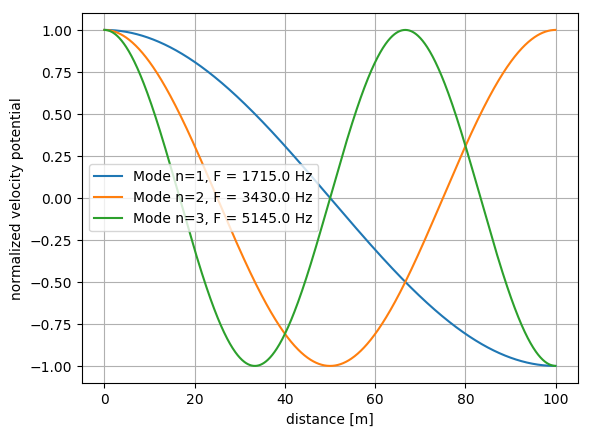

In [27]:
using PyPlot
L=100
phi_closed(x,n,L,c) = cos.(n*pi*(x./L))
x1 = 0.01:0.1:L
for n =1:3
    plot(x1,phi_closed(x1,n,L,c),label="Mode n=$(n), F = $(F_closed(n,L,c)/(2*pi)) Hz")
    hold(1)
    legend()
    xlabel("distance [m]")
    ylabel("normalized velocity potential")
    grid(1)
end
hold(0)

The cylinder is modelled using Gmsh and its nodes are shown below:

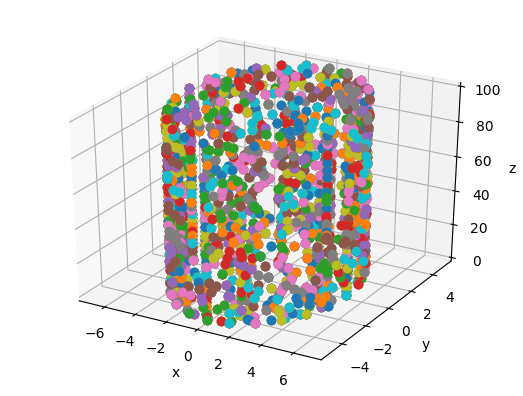

In [39]:
using PyPlot
include("src/const3D_quad/dep.jl")
NOS_GEO,ELEM,elemint,CDC = lermsh("dados/cylinder_in_quad_v.msh",3) #Read the mesh generated 
NOS = mostra_geo(NOS_GEO,ELEM);

The conventional boundary integral equation (CBIE) relates the velocity potential $\phi$ at point $x'$, known as source point, and its normal derivative at the boundary of the domain $\Gamma = \partial \Omega$  at every other point $x$ (field points). The CBIE for the BEM can be written as

\begin{equation}
 c(x') \phi(x') = \int_{\Gamma} \frac{\partial \phi (x)}{\partial n} \phi^{*}(x',x,k) d \Gamma - \int_{\Gamma} \phi(x) \frac{\partial \phi^{*}(x',x,k)}{\partial n} d \Gamma
\end{equation}
where the jump term is $c(x') = 1 / 2$ for smooth boundary on $x'$. A geometric approximation is applied to the boundary such that $\Gamma \approx \sum_{i=1}^{NE} \Gamma_i$. After the discretization, a linear system of equations is defined such that the terms of the CBIE:

\begin{equation}\label{eq_discr}
  \left[H\right]\left\{\phi \right\} = \left[G\right]\left\{\frac{\partial \phi}{\partial n} \right\}.
\end{equation}

The left and right hand sides of this matricial equation contains vectors which are populated with information about the velocity potential and its normal derivative. This matricial system can be rearranged such that all of the unknowns of this vectors are on the left side and all of the knowns are on the right side hand of the equation. This process is known as applying the boundary conditions. The result is a linear system which can be solved directly.

\begin{equation}
  \left[A\right]\left\{x \right\} = \left\{b \right\}.
\end{equation}


Once the system is solved and vector $x$ is known, one applies the boundary conditions again to build vector $\left\{\phi \right\}$ and $\left\{\frac{\partial \phi }{\partial n} \right\}$.

In [29]:
# First, matrices G and H are obtained.
# To obtain, the resonance frequency is used to obtain the wave number k = omega/c
n = 1; L = 100; c = 343*1000;
k = F_closed(n,L,c)/c
# Gaussian quadrature - generation of points and weights [-1,1]
npg=6; # Number of integration points
qsi,w = Gauss_Legendre(-1,1,npg) # Generation of the points and weights
G,H,phi_inc = cal_GeH(NOS,NOS_GEO,ELEM,k,qsi,w,0) #Compute the G and H matrices
# To apply the boundary conditions, when no BCFace is given to the lermsh command, all of the boundary conditions are assumed to be Neumann and null
# So, a new BCFace is built
BCFace = [1 1 0 # This new BCFace will impose a non null Neumann boundary condition to face 4
          2 1 0
          3 1 0
          4 1 1] # This will act like a piston in the end of the cylinder so that the cavity is perturbed
CDC = gera_CDC(ELEM,BCFace)
# Now, the boundary conditions are applied to obtain the linear system
A,b = aplica_cdc(G,H,CDC) #Applies the boundary conditions and returns matrix A and vector b for the linear system
x = A\b # Solves the linear system
phi,q = monta_Teq(CDC,x); # Applies the boundary conditions to return the velocity potential and flux

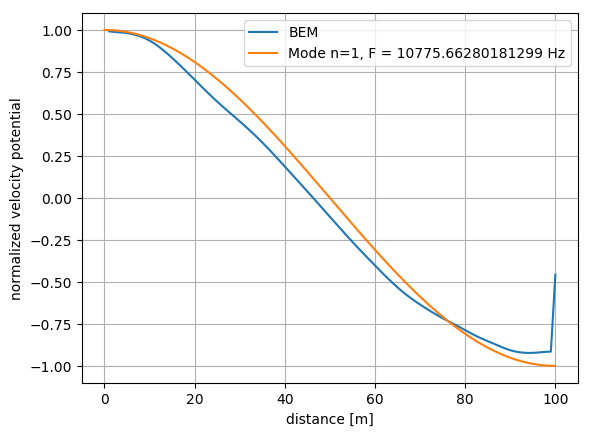

PyObject <matplotlib.legend.Legend object at 0x7ff354f9a5f8>

In [30]:
# Now, the domain points will be created
n_pint = 100
n = 1; L = 100; c = 343*1000;
PONTOS_int = zeros(n_pint,4)
for i = 1:n_pint
	PONTOS_int[i,:] = [i 0 0 (100/n_pint)*i]
end
# The velocity potential is obtained for domain points
phi_pint=calc_T_pint(PONTOS_int,NOS_GEO,ELEM,phi,q,k,qsi,w,0)
plot(PONTOS_int[:,4],real(phi_pint)./maximum(abs.(phi_pint[:,1])),label="BEM")
xlabel("distance [m]")
ylabel("normalized velocity potential")
grid(1)
hold(1)
plot(x1,phi_closed(x1,n,L,c),label="Mode n=$(n), F = $(F_closed(n,L,c)) Hz")
legend()


#### Vibrating cylinder using quadrilateral constant elements

To solve the vibrating cylinder problem, the normals of the boundary must point inwards to the cylinder. 

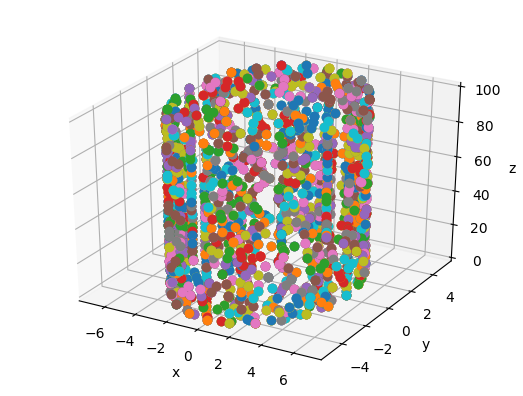

In [31]:
NOS_GEO,ELEM,elemint,CDC = lermsh("dados/cylinder_out_quad_v.msh",3) #Read the mesh generated 
NOS = mostra_geo(NOS_GEO,ELEM);

In [32]:
# Now, matrices G and H are obtained.
# To obtain, the resonance frequency is used to obtain the wave number k = omega/c
n = 1; L = 10; c = 343*1000;
k = F_closed(n,L,c)/c
G,H,phi_inc = cal_GeH(NOS,NOS_GEO,ELEM,k,qsi,w,0) #Compute the G and H matrices
# Now, the boundary conditions are applied to obtain the linear system
A,b = aplica_cdc(G,H,CDC) #Applies the boundary conditions and returns matrix A and vector b for the linear system
x = A\b # Solves the linear system
phi,q = monta_Teq(CDC,x); # Applies the boundary conditions to return the velocity potential and flux

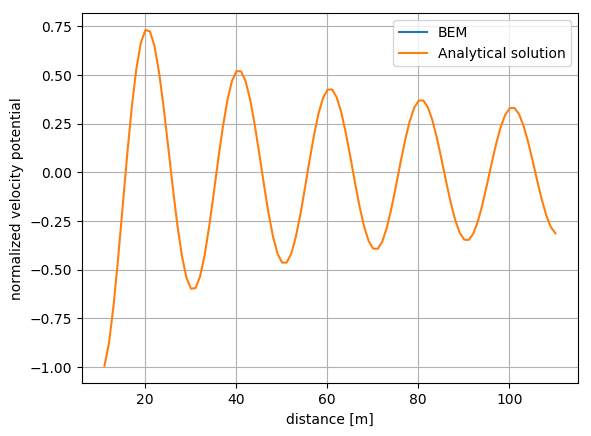

PyObject <matplotlib.legend.Legend object at 0x7ff354ee27b8>

In [40]:
# Now, the domain points will be created
using SpecialFunctions
raio = 5
n_pint = 100
PONTOS_int = zeros(n_pint,4)
dx = 10.1
dy = 10.1
dz = 50
passo = 1
phi_analytical = complex(zeros(size(PONTOS_int,1),1));
for i = 1:n_pint  # Para n_pint pontos internos
  PONTOS_int[i,:] = [i  dx+i*passo dy dz]
  bh1 = SpecialFunctions.besselh(1,2,(k)*raio);
  bh0 = SpecialFunctions.besselh(0,2,(k)*PONTOS_int[i,2]);
  phi_analytical[i,1] = (1/k).*(bh0./bh1);		#solucao anali­tica pela separacao de variaveis em coordenadas cilindricas da equacao de Helmholtz
end
# The velocity potential is obtained for domain points
phi_pint=calc_T_pint(PONTOS_int,NOS_GEO,ELEM,phi,q,k,qsi,w,0)
plot(PONTOS_int[:,2],real(phi_pint)./maximum(abs.(phi_pint[:,1])),label="BEM")
xlabel("distance [m]")
ylabel("normalized velocity potential")
grid(1)
hold(1)
plot(PONTOS_int[:,2],phi_analytical./maximum(abs.(phi_analytical[:,1])),label="Analytical solution")
legend()


In [35]:
include("src/const3D_quad/dep.jl")

telles (generic function with 1 method)

In [41]:
sum(phi_pint)

-0.0 - 0.0im